In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
data = pd.read_csv(url)

In [3]:
selected_features = [
    'Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP'
]
data = data[selected_features]

In [4]:
data.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


# **Data preparation**

In [5]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

# Fill missing values with 0
data.fillna(0, inplace=True)

In [6]:
# Create a binary variable above_average
data['above_average'] = (data['msrp'] > data['msrp'].mean()).astype(int)

In [7]:
# Split the data into train, validation, and test sets
X = data.drop(columns=['above_average', 'msrp'])
y = data['above_average']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [8]:
# Display the shapes of the resulting sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (7148, 9) (7148,)
Validation set shape: (2383, 9) (2383,)
Test set shape: (2383, 9) (2383,)


# **Question 1: ROC AUC feature importance**

In [9]:
# Initialize a dictionary to store AUC scores
auc_scores = {}

# Loop through each numerical variable and compute ROC AUC
numerical_variables = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

for variable in numerical_variables:
    auc = roc_auc_score(y_train, X_train[variable])
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[variable])
    
    auc_scores[variable] = auc

# Find the variable with the highest AUC
highest_auc_variable = max(auc_scores, key=auc_scores.get)

print(f"The numerical variable with the highest AUC is {highest_auc_variable} with AUC = {auc_scores[highest_auc_variable]}")

The numerical variable with the highest AUC is engine_hp with AUC = 0.9159001518508375


# **Question 2: Training the model**

In [10]:
# Convert categorical variables to a dictionary
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')

# Initialize and fit DictVectorizer
vectorizer = DictVectorizer(sparse=False)
X_train_encoded = vectorizer.fit_transform(X_train_dict)
X_val_encoded = vectorizer.transform(X_val_dict)

# Initialize and train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Predict probabilities on the validation set
y_val_pred_prob = model.predict_proba(X_val_encoded)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_val, y_val_pred_prob)

# Print the AUC score rounded to 3 digits
print(round(auc_score, 3))

0.982


# **Question 3: Precision and Recall**

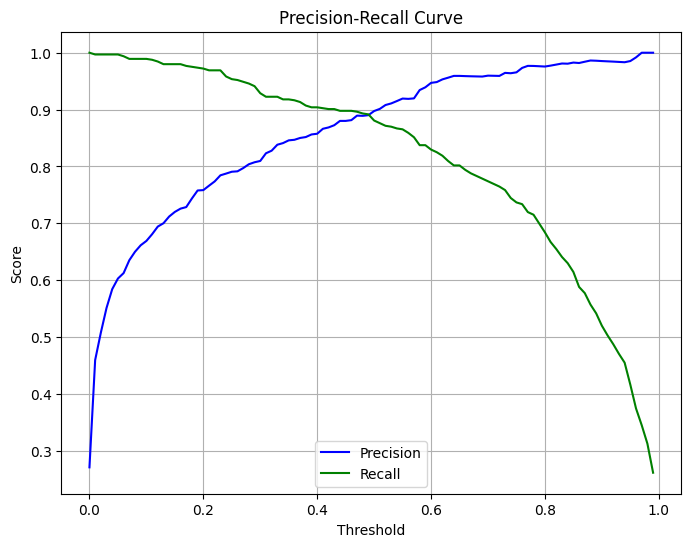

Threshold where precision and recall intersect: 0.49


In [11]:
# Initialize an array of thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.0, 0.01)

# Initialize empty lists to store precision and recall values
precision_scores = []
recall_scores = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    y_val_pred_threshold = (y_val_pred_prob >= threshold).astype(int)
    precision = precision_score(y_val, y_val_pred_threshold)
    recall = recall_score(y_val, y_val_pred_threshold)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold where precision and recall curves intersect
intersection_threshold = thresholds[np.argmin(np.abs(np.array(precision_scores) - np.array(recall_scores)))]

print("Threshold where precision and recall intersect:", intersection_threshold)

# **Question 4: F1 score**

In [12]:
from sklearn.metrics import f1_score

# Initialize empty list to store F1 scores
f1_scores = []

# Calculate F1 score for each threshold
for threshold in thresholds:
    y_val_pred_threshold = (y_val_pred_prob >= threshold).astype(int)
    f1 = f1_score(y_val, y_val_pred_threshold)
    f1_scores.append(f1)

# Find the threshold where F1 is maximal
max_f1 = max(f1_scores)
max_f1_threshold = thresholds[f1_scores.index(max_f1)]

print("Threshold where F1 is maximal:", round(max_f1_threshold, 3))

Threshold where F1 is maximal: 0.47


# **Question 5: 5-Fold CV**

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Initialize KFold with 5 splits, shuffle, and a random seed
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize an empty list to store AUC scores
auc_scores = []

# Iterate over different folds
for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Convert categorical variables to a dictionary
    X_train_fold_dict = X_train_fold.to_dict(orient='records')
    X_val_fold_dict = X_val_fold.to_dict(orient='records')

    # Initialize and fit DictVectorizer
    vectorizer_fold = DictVectorizer(sparse=False)
    X_train_fold_encoded = vectorizer_fold.fit_transform(X_train_fold_dict)
    X_val_fold_encoded = vectorizer_fold.transform(X_val_fold_dict)

    # Initialize and train logistic regression model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold_encoded, y_train_fold)

    # Predict probabilities on the validation set
    y_val_pred_prob_fold = model_fold.predict_proba(X_val_fold_encoded)[:, 1]

    # Calculate the AUC score and store it
    auc_score_fold = roc_auc_score(y_val_fold, y_val_pred_prob_fold)
    auc_scores.append(auc_score_fold)

# Calculate the standard deviation of AUC scores across different folds
std_deviation_auc = np.std(auc_scores)

print("Standard Deviation of AUC Scores:", round(std_deviation_auc, 3))

Standard Deviation of AUC Scores: 0.002


# **Question 6: Hyperparemeter Tuning**

In [14]:
from sklearn.model_selection import cross_val_score

# Define the C values to iterate over
C_values = [0.01, 0.1, 0.5, 10]

# Initialize KFold with the same parameters as previously
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize variables to track the best C, mean score, and std
best_C = None
best_mean_score = -1  # Initialize to a low value
best_std = float('inf')  # Initialize to positive infinity

# Iterate over different C values
for C in C_values:
    # Initialize and train logistic regression model with the current C value
    model_cv = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    
    # Perform cross-validation and get AUC scores for each fold
    auc_scores_cv = cross_val_score(model_cv, X_train_encoded, y_train, cv=kf, scoring='roc_auc')
    
    # Calculate the mean and standard deviation of AUC scores
    mean_score = np.mean(auc_scores_cv)
    std_score = np.std(auc_scores_cv)
    
    # Check if the current C leads to a better mean score or if it's a tie with lower std
    if mean_score > best_mean_score or (mean_score == best_mean_score and std_score < best_std):
        best_C = C
        best_mean_score = mean_score
        best_std = std_score

# Print the best C value
print("Best C:", best_C)

Best C: 10
